In [1]:
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy as np
from src import k_tree
from src.utils import data as dt
import torch
from src.k_tree import Ktree
from src.utils.data import loadData, loadData_3d
from src.metrics import Linf_simple
from src import ellipses as el

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
data = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
data = np.array([data[i].ellipse.to_vector() for i in range(len(data))])


#data = rects
learning_rate = 5e-3 # 1e-2, 5e-3
k = 3
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 1000, # 300
    "times": 20,
    "alpha": 0.1, #  projection loss 0.1
    "beta": 0.1, # latent loss 0.1
    "gamma": 0.01, # repulsive loss 0.01
    #"gamma": 0.4, # repulsive loss 0.01
    "delta": 0.05, # fuzzy scale 0.01
    "f_clk": 10, # 20
    "scale": 1, # fuzzy scale 
    "scale_flag": False,
    "number_of_centroids": k,
    "latent_size": 200,
    "encoder_activation": False,
    "encoder_depth": 5,
    "predictor_width": 5*100,
    "predictor_depth": 5,
}
n = 30
un_args = {
    "N": n,
    "M": n**2-1, # 10000 - 1
    "epsilon": 0.15 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 5e-3,
    "epochs": 3000, # 30000, 3000
    "width": 200,
    "depth": 5,
}

# thresshold = 0.1 * len(data)
threshold = k * 100
ktree = Ktree(threshold, data, el.distance_ellipse_2_point, teacher_args, un_args, student_args, device)
ktree.create_tree()






Creating student for node 0 that has 1000 data, which is more than the threshold 300.
Bounding box for node 0: [[-1996, 1999], [-1996, 1999]]
Creating teacher for node 0 with 3 centroids.
Training Teacher Model
Epoch: 50/1000.. 
 Training loss: 626.41351.. 
 torch.mean(F): 626.40076.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.01237.. 
 Repulsive: 0.00035.. 
 Memory: 31.32004.. 
 Memory: 31.32004.. 
 Output: 
 [[-149.28842   -109.73948  ]
 [ 135.38893     99.55441  ]
 [  -2.5449429   -1.8365632]]
Epoch: 100/1000.. 
 Training loss: 576.28967.. 
 torch.mean(F): 576.23291.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.05661.. 
 Repulsive: 0.00020.. 
 Memory: 28.81165.. 
 Memory: 28.81165.. 
 Output: 
 [[ -30.86092  -884.4593  ]
 [  15.28299   495.83908 ]
 [   7.424541  378.1777  ]]
Epoch: 150/1000.. 
 Training loss: 750.85590.. 
 torch.mean(F): 750.84216.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.01107.. 
 Repulsive: 0.00267.. 
 Memory: 37.54211.. 
 Memory: 37.54211.. 
 Output: 
 [[-15.6700535   1.9507

In [2]:
# Report some tree stats.
leaves = ktree.get_leaves()
number_of_nodes = ktree.number_of_nodes

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)
print(number_of_nodes)

Tree height is 4.
Created 9 leaves with sizes
[41, 152, 118, 85, 195, 121, 116, 89, 83]
14


The percentage of correct predictions per layer is: 
[96.         87.66666667 80.         53.66666667]
The percentage of correct predictions per layer is: 
[95.33333333 88.66666667 80.         49.33333333]
The percentage of correct predictions per layer is: 
[97.         90.33333333 83.         51.66666667]
The percentage of correct predictions per layer is: 
[98.66666667 91.66666667 84.         54.33333333]
The mean percentage of correct predictions is: 
[96.75       89.58333333 81.75       52.25      ]


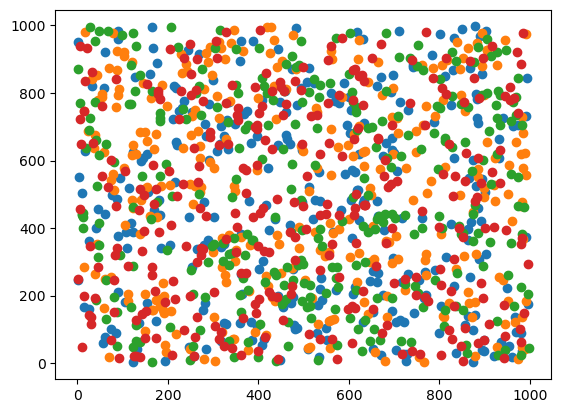

In [3]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        brute_force = ktree.root.query(query_point)

        for j, pred in enumerate(preds_per_layer):
            if np.array_equal(pred, brute_force):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[95.         89.         82.33333333 52.66666667]
The percentage of correct predictions per layer is: 
[99.         92.33333333 84.66666667 55.66666667]
The percentage of correct predictions per layer is: 
[97.66666667 91.66666667 85.33333333 54.33333333]
The percentage of correct predictions per layer is: 
[98.33333333 92.66666667 84.66666667 51.33333333]
The mean percentage of correct predictions is: 
[97.5        91.41666667 84.25       53.5       ]


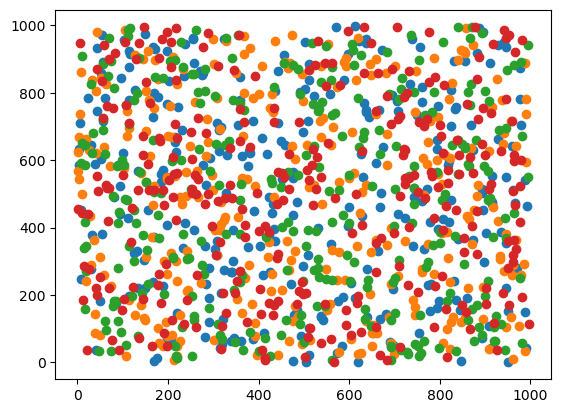

In [4]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=2)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(2)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[100.          94.33333333  90.33333333  59.33333333]
The percentage of correct predictions per layer is: 
[99.33333333 97.         94.33333333 62.        ]
The percentage of correct predictions per layer is: 
[98.33333333 95.         93.         65.66666667]
The percentage of correct predictions per layer is: 
[99.33333333 96.         91.33333333 60.33333333]
The mean percentage of correct predictions is: 
[99.25       95.58333333 92.25       61.83333333]


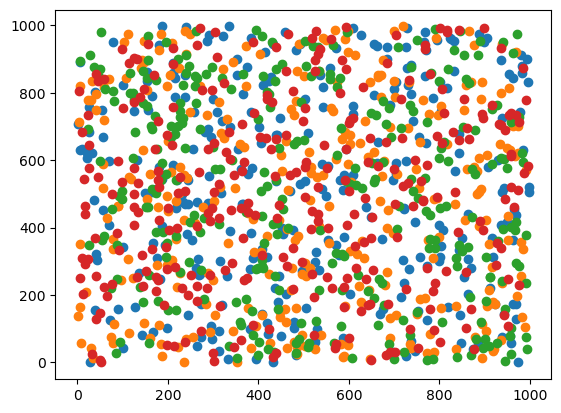

In [5]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=5)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(5)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[99.66666667 98.         96.33333333 65.33333333]
The percentage of correct predictions per layer is: 
[100.          98.66666667  96.66666667  65.66666667]
The percentage of correct predictions per layer is: 
[99.66666667 98.33333333 95.66666667 62.        ]
The percentage of correct predictions per layer is: 
[99.33333333 98.66666667 97.66666667 60.        ]
The mean percentage of correct predictions is: 
[99.66666667 98.41666667 96.58333333 63.25      ]


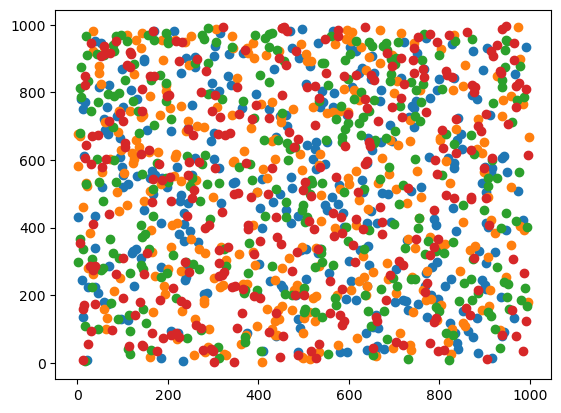

In [6]:
#find the accuracy of detecting one of the first 5 nearest neighbors
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=10)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(10)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[100. 100. 100.  63.]
The percentage of correct predictions per layer is: 
[100.         100.         100.          64.66666667]
The percentage of correct predictions per layer is: 
[100.         100.         100.          64.33333333]
The percentage of correct predictions per layer is: 
[100.         100.         100.          72.66666667]
The mean percentage of correct predictions is: 
[100.         100.         100.          66.16666667]


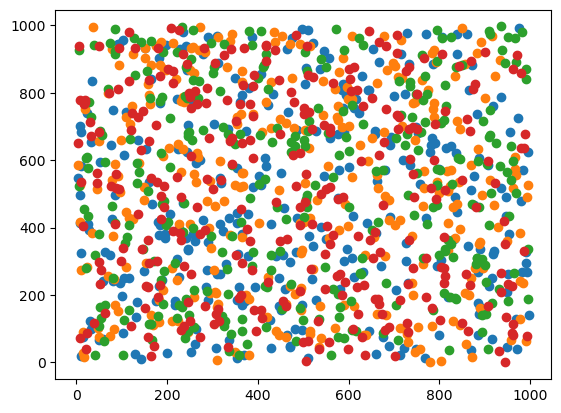

In [7]:
#find the accuracy of detecting one of the first 10 nearest neighbors
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=50)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(50)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[100.         100.         100.          65.66666667]
The percentage of correct predictions per layer is: 
[100. 100. 100.  61.]
The percentage of correct predictions per layer is: 
[100.         100.         100.          63.33333333]
The percentage of correct predictions per layer is: 
[100.         100.         100.          63.66666667]
The mean percentage of correct predictions is: 
[100.         100.         100.          63.41666667]


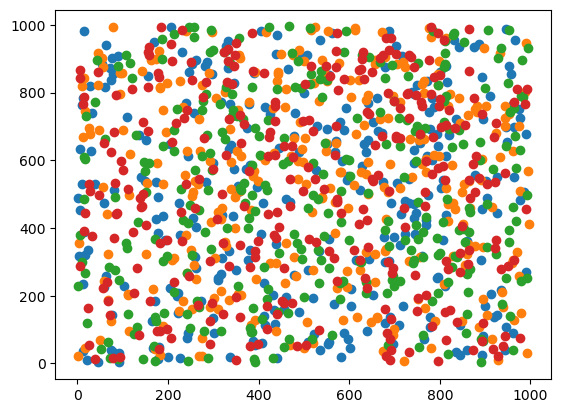

In [8]:
#find the accuracy of detecting one of the first 10 nearest neighbors
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=100)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(100)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[100.         100.         100.          66.66666667]
The percentage of correct predictions per layer is: 
[100. 100. 100.  65.]
The percentage of correct predictions per layer is: 
[100. 100. 100.  67.]
The percentage of correct predictions per layer is: 
[100. 100. 100.  64.]
The mean percentage of correct predictions is: 
[100.         100.         100.          65.66666667]


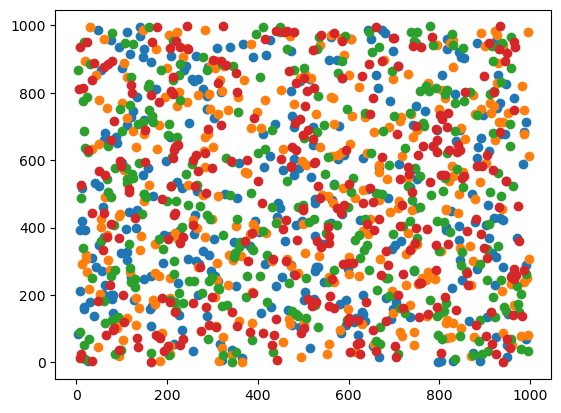

In [9]:
#find the accuracy of detecting one of the first 10 nearest neighbors
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(*x_lim), np.random.randint(*y_lim)])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=100)

        for i, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[i]) for i in range(100)):
                correct_predictions_per_layer[i] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[97.2 89.  80.6 47.8]
The mean percentage of correct predictions is: 
[97.2 89.  80.6 47.8]


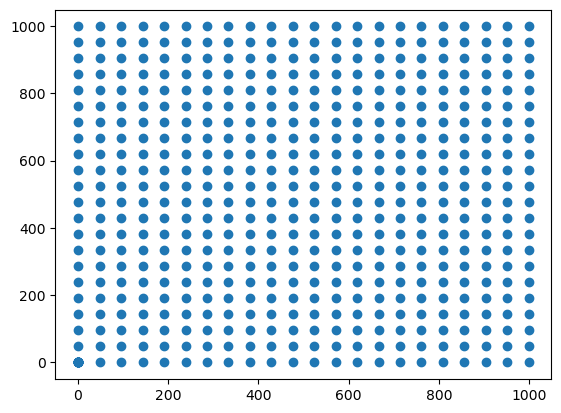

In [10]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/1000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 1:
    nop =  500
    random_p = torch.zeros(nop, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]
    num = int(np.sqrt(nop))
    for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
        for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
            random_p[i*num+j] = torch.Tensor([x, y])
    
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        brute_force = ktree.root.query(query_point)

        for j, pred in enumerate(preds_per_layer):
            if np.array_equal(pred, brute_force):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

In [11]:
# Report some tree stats.
leaves = ktree.get_leaves()
number_of_nodes = ktree.number_of_nodes

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)
print(number_of_nodes)

Tree height is 4.
Created 9 leaves with sizes
[41, 152, 118, 85, 195, 121, 116, 89, 83]
14


The percentage of correct predictions per layer is: 
[99.4 95.  94.6 18.6]
The mean percentage of correct predictions is: 
[99.4 95.  94.6 18.6]


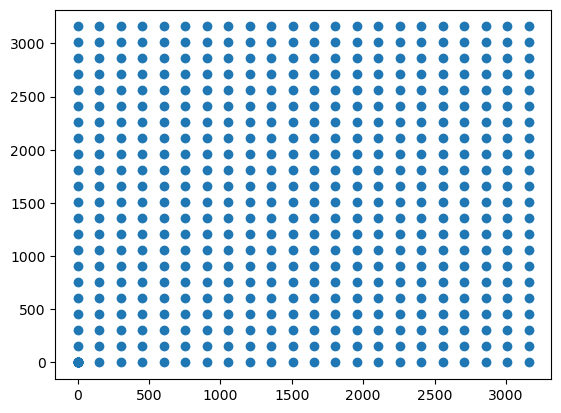

In [12]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

data_full = np.load('./data/ellipses/10000el_1_3.npy', allow_pickle=True)
boxes_x_min = min([data_full[i].x_min for i in range(len(data_full))])
boxes_x_max = max([data_full[i].x_max for i in range(len(data_full))])
boxes_y_min = min([data_full[i].y_min for i in range(len(data_full))])
boxes_y_max = max([data_full[i].y_max for i in range(len(data_full))])

while times < 1:
    nop =  500
    random_p = torch.zeros(nop, 2)
    x_lim = [boxes_x_min, boxes_x_max]
    y_lim = [boxes_y_min, boxes_y_max]
    num = int(np.sqrt(nop))
    for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
        for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
            random_p[i*num+j] = torch.Tensor([x, y])
    
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=2)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred[0], k_nearest_neighbors[ki]) for ki in range(2)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)